<a href="https://colab.research.google.com/github/Stegi56/Face-Covering-Detection/blob/main/Face_Covering_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Set up torch

In [ ]:
import torch #ref Lab 9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Load Google drive and get files

In [ ]:
import os
os.environ["OPENCV_ENABLE_NONFREE"] = "1"
from google.colab import drive

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Face Covering Detection'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/drive
['CV2024_CW_Dataset.zip', 'CV2024_CW_Dataset', 'Report template.docx', 'Coursework UG - Sit.pdf', 'Marking scheme.pdf', 'Coursework UG - Sit.gdoc', 'Face Covering Detection.ipynb']


Load Zip File (Ref Lab 9)

In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

## Load images and labels
Since the training and test data is extremely unbalanced I am combining the two to split them again into test and train more evenly.

I am using downsampling since the majority class is significantly greater and I fear duplication on this scale would risk overfitting.

Ref Lab 6

In [ ]:
from skimage import io
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def import_selected_data(type):
  images = []
  labels = []

  for image in os.listdir(os.path.join(type, "images")):
    images.append(io.imread(os.path.join(type, "images", image)))
    match open(
      os.path.join(type, "labels", image.split(".")[0] + ".txt"),
      "r"
      ).read():
      case "0":
        label = "no mask"
      case "1":
        label = "good mask"
      case "2":
        label = "bad mask"

    labels.append(label)

  return images, labels

X_train_balanced, y_train_balanced = [], []
X_test, y_test = [], []
X_validation, y_validation = [], []

def loadData():
  X, y = import_selected_data("train")

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, shuffle=True, stratify=y)

  print("training data:")
  print(Counter(y_train))

  X_train_indexes = np.arange(len(X_train)).reshape(-1, 1) # convert images to indexes for sampling

  undersample_strategy = {"good mask": 200, "no mask":200} #undersample good masks
  rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=56)


  oversample_strategy = {"bad mask": 200} # oversample bad and no mask
  ros = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=56)

  pipeline = Pipeline([("undersample", rus), ("oversample", ros)]) #combine samplers

  # Resample indices
  X_balanced_indexes, y_train_balanced = pipeline.fit_resample(
      X_train_indexes, y_train
  )

  indices = X_balanced_indexes.ravel()
  X_train_balanced = [X_train[i] for i in indices] #rebuild images using generated indexes

  print("\nBalanced training data:")
  print(Counter(y_train_balanced))

  print("\nTest data:")
  print(Counter(y_test))

  X_validation, y_validation = import_selected_data("test")
  print("\nValidation data:")
  print(Counter(y_validation))

loadData()

training data:
Counter({'good mask': 1552, 'no mask': 301, 'bad mask': 62})

Balanced training data:
Counter({'bad mask': 200, 'good mask': 200, 'no mask': 200})

Test data:
Counter({'good mask': 388, 'no mask': 75, 'bad mask': 16})

Validation data:
Counter({'good mask': 388, 'no mask': 51, 'bad mask': 19})


# SIFT + SVM

Get points of interest

Ref Lab 6

In [ ]:
import cv2
from skimage import img_as_ubyte, color
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics


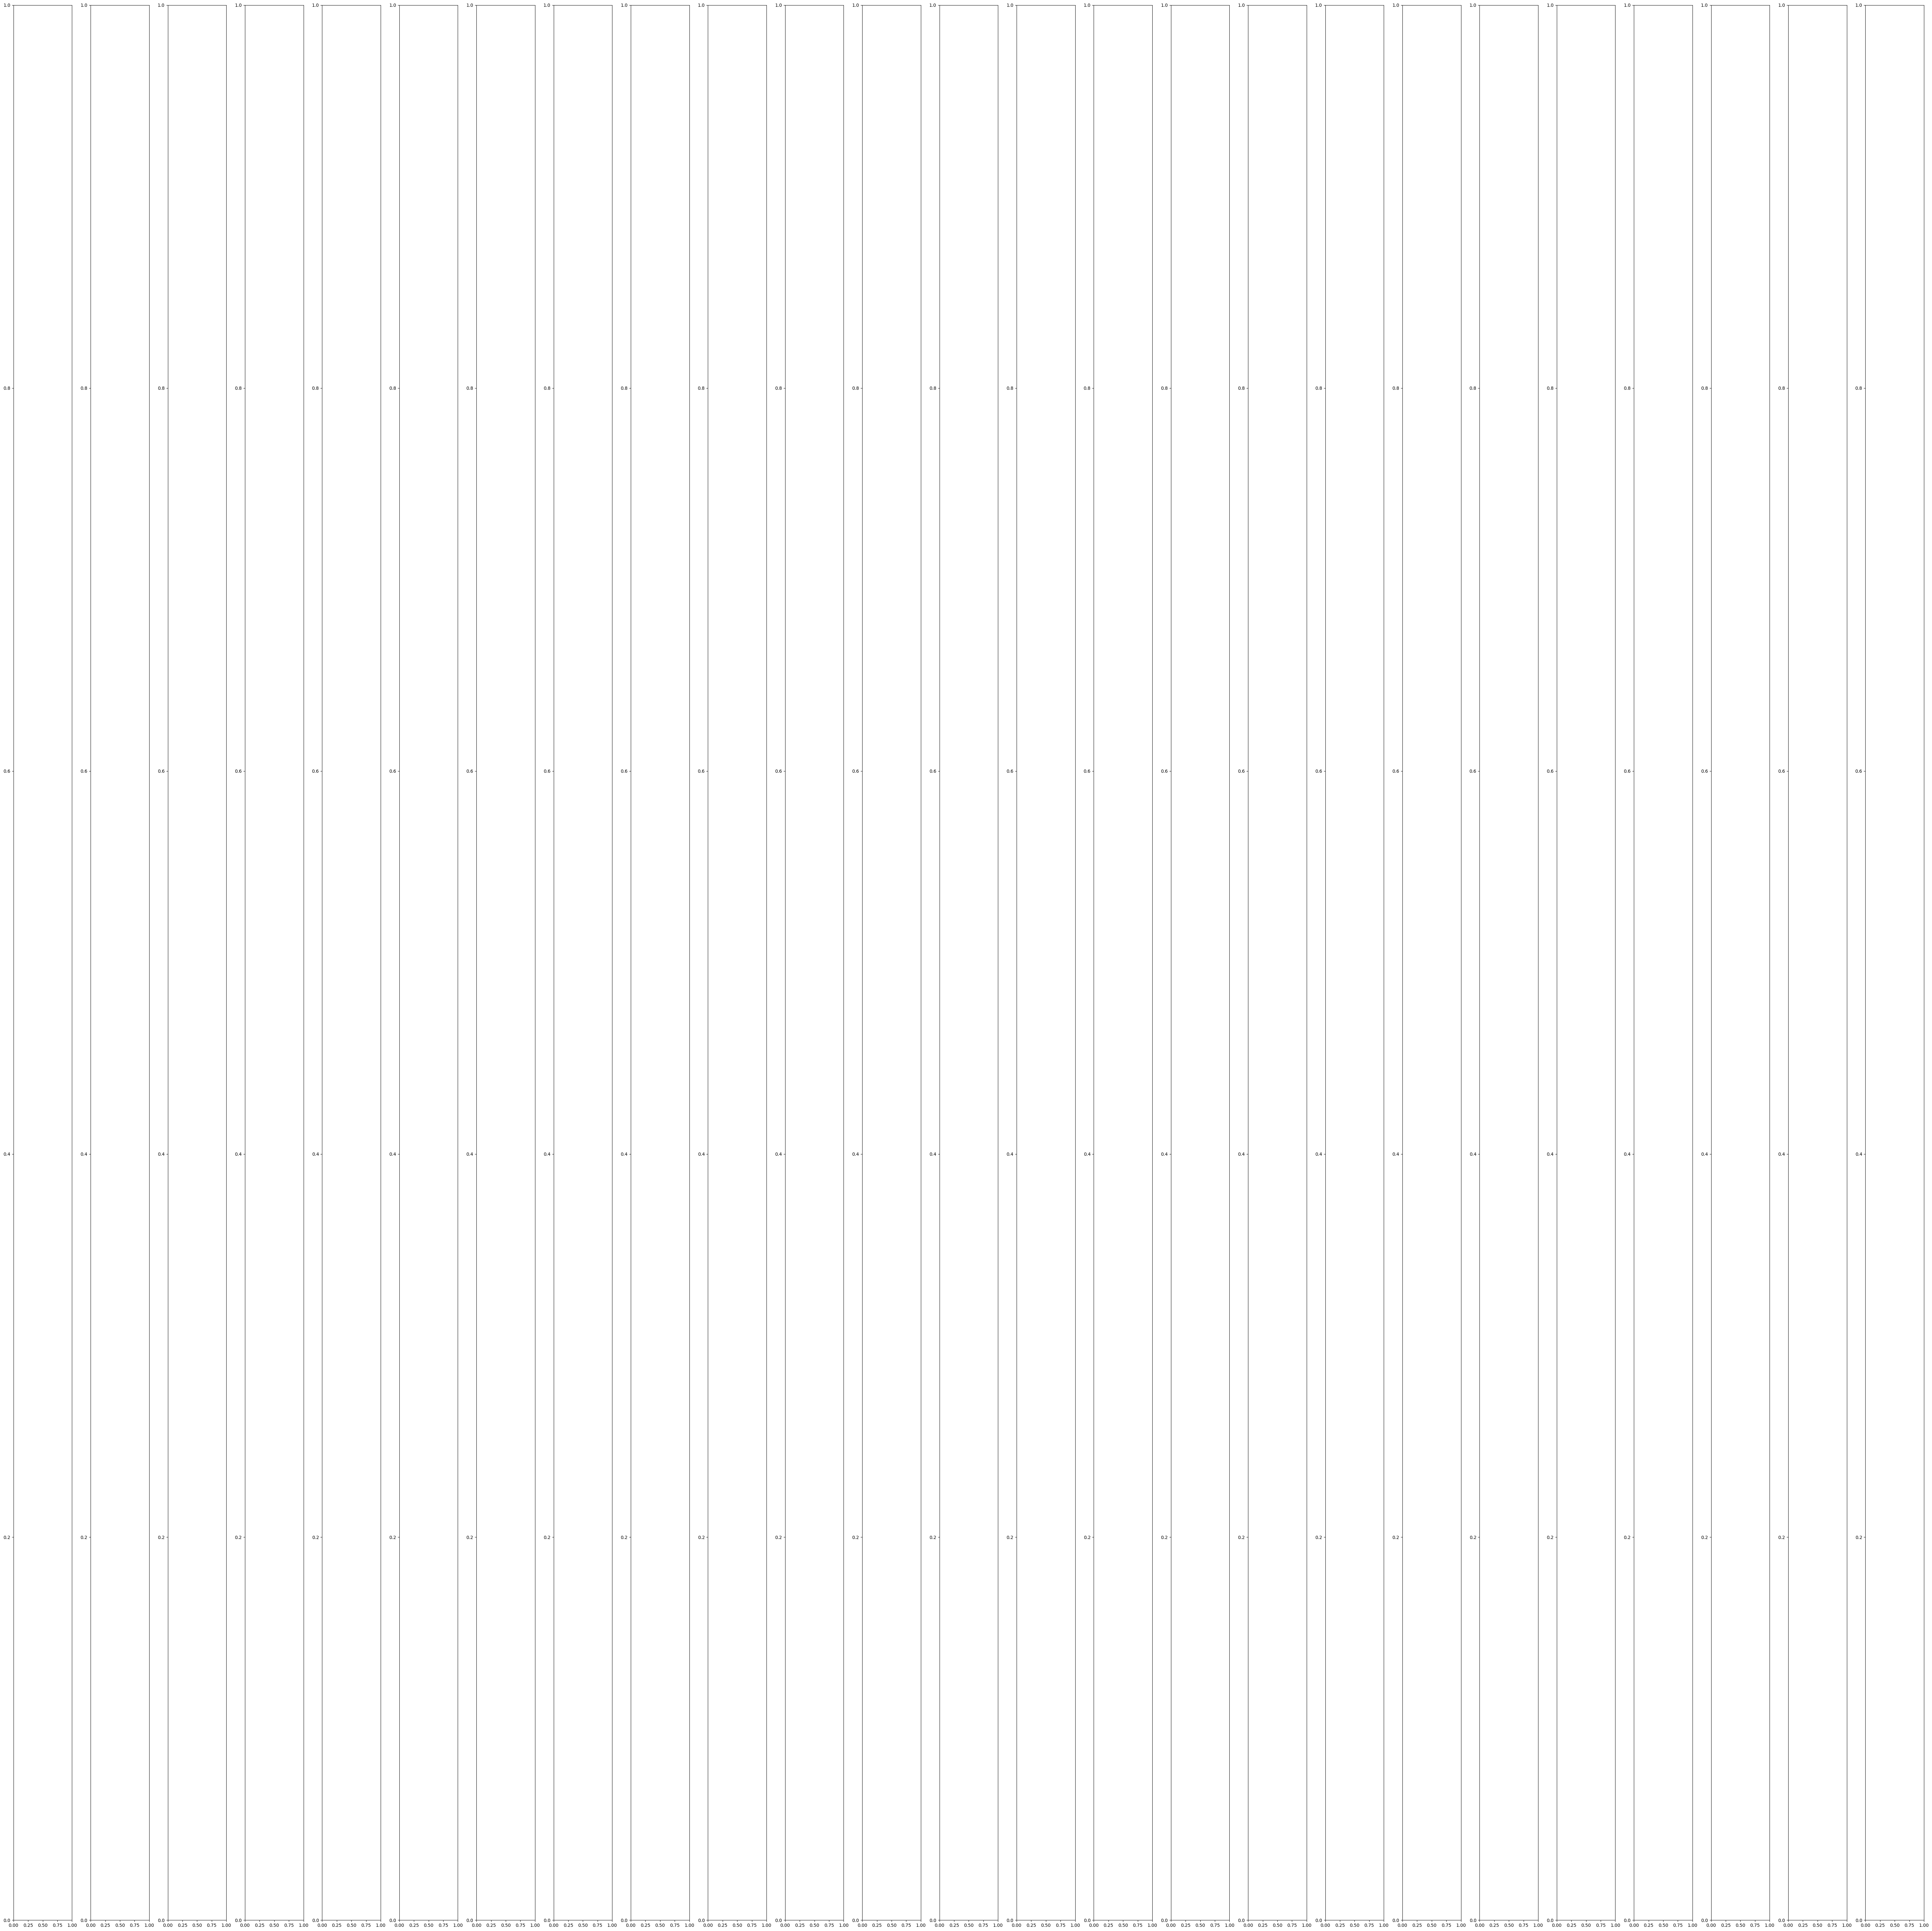

ValueError: need at least one array to concatenate

In [ ]:
sift = cv2.SIFT_create(
    nfeatures=150,
    nOctaveLayers=15,
    contrastThreshold=0.01,
    edgeThreshold=10,
    sigma=1.000001
)

des_list = []
y_train_list = []

def setPOI():
  fig, ax = plt.subplots(1, 25, figsize=(60, 60))

  def unsharp_mask(image, sigma=1.0, strength=4): #ref https://www.opencvhelp.org/tutorials/image-processing/how-to-sharpen-image/
      blurred = cv2.GaussianBlur(image, (0, 0), sigma)
      sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
      return sharpened

  for i in range(len(X_train_balanced)):
      img = img_as_ubyte(color.rgb2gray(X_train_balanced[i]))
      img_sharp = unsharp_mask(img) # low resolution images look extremely blurry so i try define edges with sharpen
      kp, des = sift.detectAndCompute(img_sharp, None)

      if i<25:
          img_with_SIFT = cv2.drawKeypoints(img_sharp, kp, img_sharp)
          ax[i].imshow(img_with_SIFT)
          ax[i].set_axis_off()

      if des is not None:
          des_list.append(des)
          y_train_list.append(y_train_balanced[i])

  fig.tight_layout()
  plt.show()

  # Convert to array for easier handling
  des_array = np.vstack(des_list)
setPOI()

Clustering descriptors Ref Lab 6

In [ ]:
k = len(np.unique(y_train)) * 30 # more than 10 due to radically different resolutions and facial features

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0]
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

Generate histograms of codewords Ref Lab 6

In [ ]:
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

Train SVM

In [ ]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(C= 25, kernel='poly')

# We learn the digits on the first half of the digits
classifier.fit(hist_array, y_train_list)

SVC(C=25, kernel='poly')

Extract descriptors from test set

In [ ]:
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

Predict each test image

In [ ]:
y_pred = classifier.predict(hist_array).tolist()

Visualise labels


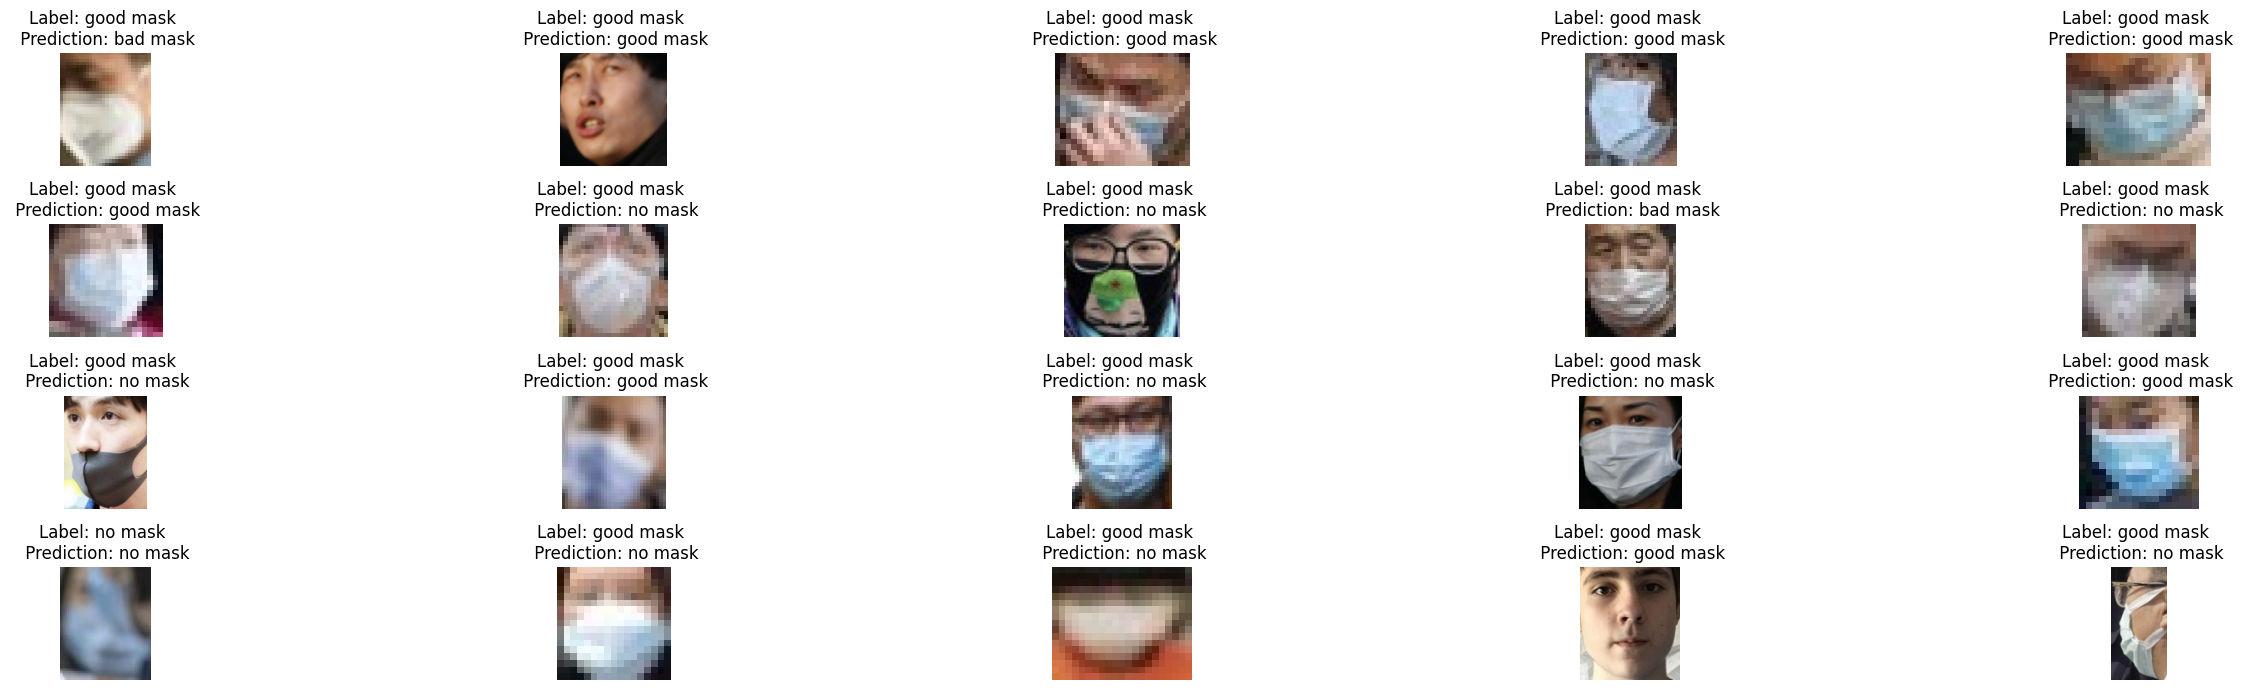

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(28, 7))
ax = axes.ravel()

for i in range(20):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

Kowalski analysis

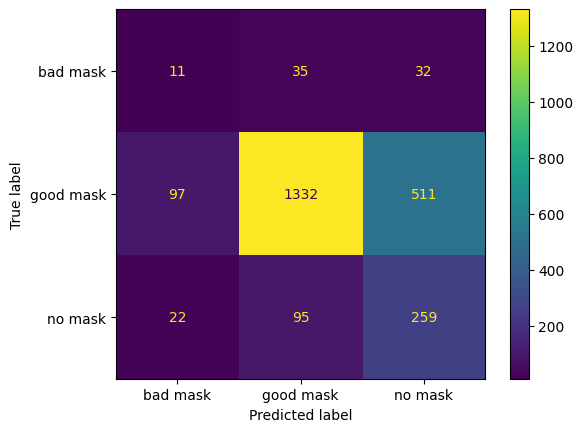

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test, y_pred)}\n""")

Classification report for classifier SVC(C=25, kernel='poly'):
                    precision    recall  f1-score   support

    bad mask       0.08      0.14      0.11        78
   good mask       0.91      0.69      0.78      1940
     no mask       0.32      0.69      0.44       376

    accuracy                           0.67      2394
   macro avg       0.44      0.51      0.44      2394
weighted avg       0.79      0.67      0.71      2394


